# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [11]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [12]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

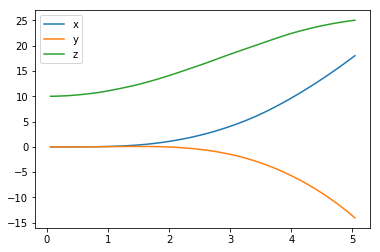

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

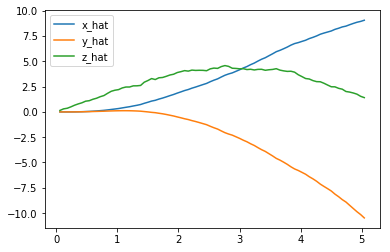

In [14]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

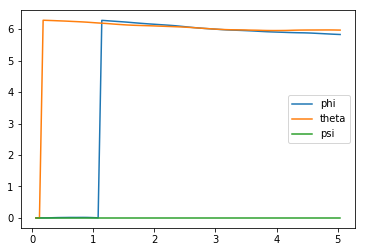

In [15]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

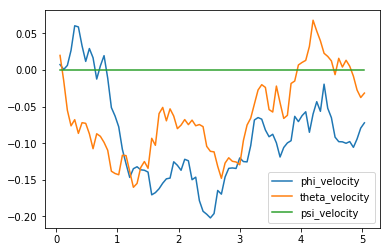

In [16]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

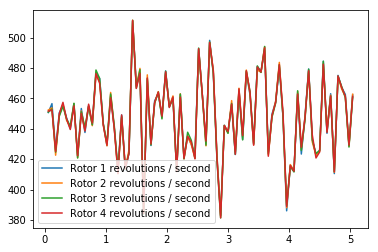

In [17]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [18]:
import csv
import numpy as np
from task import Task
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 1000
target_pos = np.array([0., 0., 50.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state 
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, score =  -0.161 (best =  -0.131), noise_scale = 3.25

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [2]:
## Teach the Quadcopter to take off from ground with initial 0 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
#          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
#          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4'

# import necessary libraries
from agents.agent_DDPG import DDPG
import csv
import numpy as np
import sys
import pandas as pd
from task import Task

# Starting states
num_episodes = 700 # iterate episode 600 times
target_pos = np.array([0., 0., 50.])# target location, 50 m off ground, take-off setup
file_output = 'data.txt' # save data to 'data.txt' file

# Setup
task = Task(target_pos=target_pos) # initialize simulation incident with zero values for all settings except for target location
agent = DDPG(task) # initialize agent incident using Deep Deterministic Policy Gradients
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4', 'reward', 'i_episode','episode_reward','average_distance','average_x','average_y','average_z']
results = {x : [] for x in labels}

with open(file_output, 'w') as csvfile: # opens file to write info into
    writer = csv.writer(csvfile) # writing incident
    writer.writerow(labels) # write labels for each column in the file
    for i_episode in range(1, num_episodes+1):
        state = agent.reset_episode() # start a new episode
        episode_reward = 0
        average_x = 0
        average_y = 0
        average_z = 0
        average_distance = 0
        counter=0
        while True:
            """uses self.actor_local.model.predict(state)[0] from agent_DDPG.py to generate actions"""
            action = agent.act(state) # produce action values
            next_state,reward,done = task.step(action) #let the simulating environment create results from action values
            agent.step(action, reward, next_state, done) #let the DDPG agent utilize OUNoise, ReplayBuffer, Actor, and Critic to update gradients for NN
            state = next_state
            episode_reward += reward
            average_x += task.sim.pose[0]
            average_y += task.sim.pose[1]
            average_z += task.sim.pose[2]
            average_distance += ((task.sim.pose[0]-target_pos[0])**2+(task.sim.pose[1]-target_pos[1])**2+(task.sim.pose[2]-target_pos[2])**2)**0.5
            counter += 1
            if done:
                average_x = average_x/counter
                average_y = average_y/counter
                average_z = average_z/counter  
                average_distance = average_distance/counter
                to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action) + [reward] + [i_episode] + [episode_reward] + [average_distance] + [average_x] + [average_y] + [average_z]
                for ii in range(len(labels)):
                    results[labels[ii]].append(to_write[ii])            
                writer.writerow(to_write)                 
                print("\rEpisode={:4d}, Episode Reward={:7.2f}, Score={:7.2f} (Best={:7.2f}), Action({:7.2f},{:7.2f},{:7.2f},{:7.2f}), Average Distance({:7.2f},{:7.2f},{:7.2f}) ".format(
                    i_episode,episode_reward, agent.score, agent.best_score,action[0],action[1],action[2],action[3], average_x, average_y, average_z), end="")  # [debug]
                break
        sys.stdout.flush()


Using TensorFlow backend.


Episode= 700, Episode Reward=  76.12, Score=   0.91 (Best=   0.92), Action(   0.22,   0.28, 900.24, 900.29), Average Distance(  -0.00,   5.66,  40.92) 

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

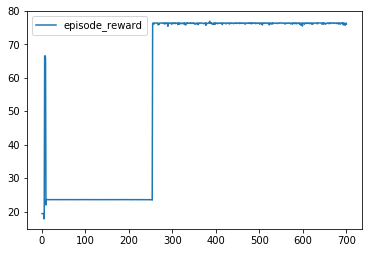

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['i_episode'], results['episode_reward'], label='episode_reward')
plt.legend()
_ = plt.ylim()

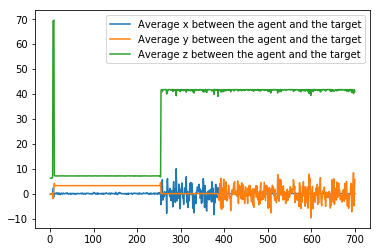

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['i_episode'], results['average_x'], label='Average x between the agent and the target')
plt.plot(results['i_episode'], results['average_y'], label='Average y between the agent and the target')
plt.plot(results['i_episode'], results['average_z'], label='Average z between the agent and the target')
plt.legend()
_ = plt.ylim()

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**: <br>
- Goal : Quadcopter teaches itself to take off to a specified height from sitting idel on the ground with no moving parts as initial values.<br>
- Distance : Instead of using given `(abs(self.sim.pose[:3] - self.target_pos)).sum()`, I used distance formula `((x1-x2)^2 + (y1-y2)^2 + (z1-z2)^2)^0.5` which I thought was more accurate metric.<br>
- Reward : I used `reward = np.tanh(2-(0.02*distance))` as reward function. This particular reward limits reward between (-1,1) and helped learning by stabilizing gradient update process.


**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**
- I used DDPG (Deep Deterministic Policy Gradients) which is an Actor-Critic method. On top of that, Ornstein-Uhlenbeck Noise and Replay Buffer were sprinkled in to improve performance.
    - Actor-Critic Method : Neural Networks were utilized to learn necessary weights. This method allows more flexibility since policy update(actor) and value update(critic) are separated. This separation decouples the parameters that are updated and produces target values.
    - Ornstein-Uhlenbeck Noise : Introduce random samples(noises) from Gaussian distribution, but each samples are closer. This helps in our Quadcopter setting, since we want random noise for exploration, but we don't want the Quadcoptor to fly like an UFO.
    - Replay Buffer - Stores experiences in tuples and samples stored values at random, and this helps us break the correlation and prevent action values from oscillating or diverging catastrophically.
- Final Parameters:
    - buffer_size for Replay Buffer = 1000000
    - batch_size for Replay Buffer = 128 <- 2,4,8,16,64,128,256,,,, allows quicker iteration in modern computer memories
    - gamma for Q_target updates= 0.99 <- High gamma so that agent is interested in the distant future's rewards as well
    - tau for weight updates = 0.001 <- Put more emphasis on newly learned weights for weight updates
- Neural Network was used for both Actor and Critic :
    - Actor
        - (Input Layer)(Dense Layer with 128 units)(Regularizer)(Batch Normalization)(Relu Activation)(Dropout 0.2) 
        - L2 regularizer : 0.01 <- Help penalize exploding gradients and prevent overfitting by allowing generalization.
        - Batch Normalization : Optimizes training NN by reducing covariate shift by providing NN with inputs that are zero mean/unit variance.
        - Relu Activation is way to go. It helps NN to focus on nodes that are relevant by dropping negative nodes.
        - Dropout : 0.2 <- Prevents overfitting by utilizing different NN nodes instead of using specific ones over and over
        - Optimizer(Adam) Learning Rate : 0.01 <- I found this learning rate to be effective at algorithm converging the quickest
    - Critic
        - Very similar to those of Actor 
        - Optimizer(Adam) Learning Rate : 0.001 <- I found this learning rate to be effective at algorithm converging the quickest
    

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:
- It was pretty challenging initially to find right reward function, hyperparameter, NN layer structures, and etc to yield satisfying result. Everything was important, but I would say designing robust and working NN layer structure was the most important step in this project.
- As seen in Episode Rewards vs Episode graph below, it followed step change in learning the right weights. Once the algorithm gradually shifted and found weights that worked, it quickly learned weights that yielded almost maximum reward toward the end.
- Final performance of the agent improved significantly over time. It started out as having fairly low and instable episode rewards per episode. However, as the agent started learning the right weights, average episode reward increased until it capped out at around 76.306 over last 30 episodes. Also, graph of average x,y, and z distance over entire episodes shows that the agent learned to perform a vertical takeoff. Agent's average location for (x,y,z) stayed very close to target location (0,0,50) for each episode.

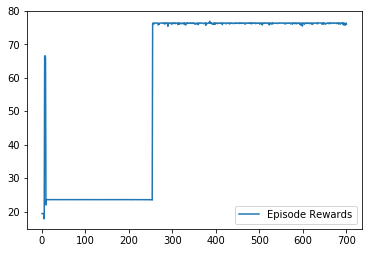

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['i_episode'], results['episode_reward'], label='Episode Rewards')
plt.legend()
_ = plt.ylim()

In [11]:
print("Final performance (mean rewards over last 30 episodes): {}".format(np.sum(results['episode_reward'][-30:])/30))

Final performance (mean rewards over last 30 episodes): 76.30575938735518


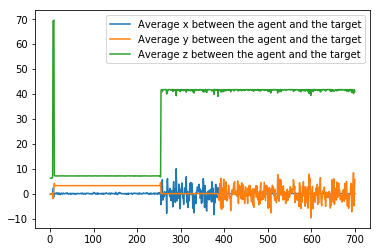

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['i_episode'], results['average_x'], label='Average x between the agent and the target')
plt.plot(results['i_episode'], results['average_y'], label='Average y between the agent and the target')
plt.plot(results['i_episode'], results['average_z'], label='Average z between the agent and the target')
plt.legend()
_ = plt.ylim()

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
- Single-handedly the most difficult task of this project was defining and designing working Neural Network structures for Actor and Critic models. This was the case because Actor and Critic models were the core driving engines of learning optimal weights, besides reward function, to generate action values that will enable Quadcopter to behave in desired manner. Also, tuning hyperparameters were difficult as well since I lacked deep understanding of their effects on overall performance. However, I was able to quickly able to learn to tune the hyperparameters through trial-and-error and research.
- Teaching Quadcopter to learn how to reach target location, and RL problems in general, was very interesting since it was analogous to teaching a real person to learn a new task. With right tools (hyperparameters), guidance (reward function), and curriculum (structures) the Quadcopter was able to learn what I wanted to teach, which was very similar to how people learn.